Root Mean Squared Error (RMSE) on test data = 2.8364696882145237
MAE: 2.6620522790329626
R2: 0.6697929507573805


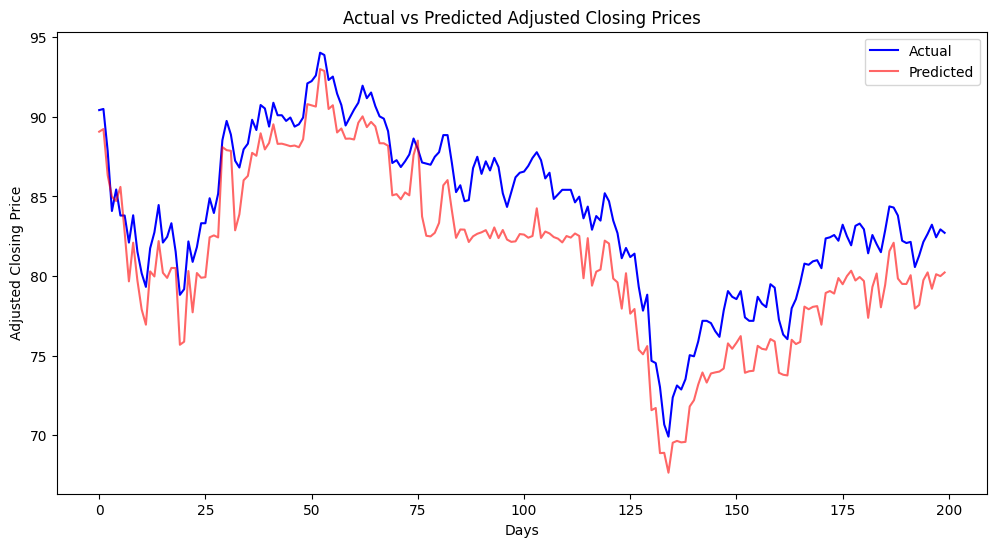

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("ImprovedStockPrediction").getOrCreate()

# Load the data from the CSV into a DataFrame
df = spark.read.csv("/content/sample_data/data_stocks.csv", header=True, inferSchema=True)
df=df.limit(1000)
# Window function to order by date (for features that require looking at previous rows)
w = Window.partitionBy().orderBy("date")

# Feature Engineering
# 1. Create a lagged column for the 'close' price (i.e., previous day's close)
df = df.withColumn("lag_close_1", F.lag(df.close).over(w))

# 2. Calculate daily return - how much did the price change in percentage from opening to closing
df = df.withColumn("daily_return", (df.close - df.open) / df.open)

# 3. Calculate intra-day volatility - difference between the highest and lowest prices of the day
df = df.withColumn("intra_day_volatility", df.high - df.low)

# 4. Calculate daily volatility - change in closing price from the previous day
df = df.withColumn("daily_volatility", df.close - df.lag_close_1)

# 5. Calculate a 7-day moving average for the closing prices
df = df.withColumn("7_day_avg_close", F.avg(df.close).over(w.rowsBetween(-6, 0)))

# 6. Binary indicator if there was a dividend
df = df.withColumn("is_dividend", F.when(df["dividend amount"] > 0, 1).otherwise(0))

# 7. Binary indicator if there was a stock split
df = df.withColumn("is_split", F.when(df["split coefficient"] != 1, 1).otherwise(0))

# Drop any rows with NA values (which might have been introduced due to lagging operations)
df = df.dropna()

# Assemble the features into a single vector for MLlib consumption
feature_columns = ["open", "high", "low", "close", "volume", "daily_return",
                   "intra_day_volatility", "daily_volatility", "7_day_avg_close",
                   "is_dividend", "is_split"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Split the data into a training set and a test set.
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(df_assembled.count() * 0.8)
train_data = df_assembled.orderBy("date").limit(train_count)
test_data = df_assembled.subtract(train_data)

# Model Training
# Gradient Boosted Trees are chosen due to their robustness and ability to model non-linear patterns
gbt = GBTRegressor(labelCol="adjusted close", featuresCol="features", maxIter=50)
model = gbt.fit(train_data)
predictions = model.transform(test_data)

# Model Evaluation
# Compute the RMSE (Root Mean Squared Error) for the predictions
evaluator_rmse = RegressionEvaluator(labelCol="adjusted close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

# Compute other metrics: Mean Absolute Error (MAE) and R-squared (R2)
for metric in ["mae", "r2"]:
    evaluator = RegressionEvaluator(labelCol="adjusted close", predictionCol="prediction", metricName=metric)
    value = evaluator.evaluate(predictions)
    print(f"{metric.upper()}: {value}")

# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predictions.select("adjusted close", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["adjusted close"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

# Terminate the Spark session
spark.stop()

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a50b4223d09e83dcd5ac049556bd6d7dd033fd533f7ed1e58091f292c59c60a1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
